In [203]:

%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-pinecone langchain-google-genai

In [204]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
from pinecone import Pinecone, ServerlessSpec
pinecone_object = Pinecone(api_key=PINECONE_API_KEY)


In [205]:

from langchain_google_genai import GoogleGenerativeAIEmbeddings
embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [206]:
index_name = 'arman-shoe-store'
pinecone_object.create_index(
                name=index_name,
                dimension=768,
                metric='cosine',
                spec=ServerlessSpec(cloud='aws',region='us-east-1')
)


PineconeApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2024-07', 'X-Cloud-Trace-Context': '6c11ecb7f02104d0f10b85e27188fd10', 'Date': 'Sat, 04 Jan 2025 19:10:37 GMT', 'Server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}


In [207]:

index= pinecone_object.Index(index_name)

In [208]:
from langchain_pinecone import PineconeVectorStore
vector_store = PineconeVectorStore(index=index,embedding=embedding)

In [ ]:

import fitz
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        text += page.get_text("text")
    return text
pdf_path = "/content/sample_data/combined1.pdf"


pdf_text = extract_text_from_pdf(pdf_path)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True,
)

docs = [Document(page_content=pdf_text)]

documents = text_splitter.split_documents(docs)


In [ ]:
random_ids = [str(index) for index, _ in enumerate(documents)]

response = vector_store.add_documents(documents=documents, ids=random_ids)
print(response)

In [209]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [210]:
from langgraph.graph import MessagesState
from langchain.prompts import PromptTemplate
def answer_to_user(query: str):
  context_with_scores =vector_store.similarity_search_with_score(query)
  filtered_context = [res.page_content for res, score in context_with_scores if score > 0.65]
  return filtered_context
  prompt_template = PromptTemplate(
            input_variables=["filtered_context", "user_query"],
            template="""
                You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
                 If you don't know the answer.


                ### Question:
                {user_query}

                ### Context:
                {filtered_context}



                ### Guidelines for Responses:
                1. Answer based on the provided context.
                2. Be concise, friendly, and professional.


                ## Response:

            """
        )

  formatted_prompt = prompt_template.format(filtered_context=filtered_context, user_query=query)
  final_result = llm.invoke(formatted_prompt)
  return final_result


In [211]:
final_answer=answer_to_user('how we can check my order status')
print(final_answer)

['Q: What should I do if my order is not confirmed?\nAns: Check your email for confirmation or contact customer support with your order details.\nQ: How do I cancel an order?\nAns: Go to "My Orders," select the order, and click "Cancel" before it is shipped.\nQ: Can I place an order over the phone?\nAns: Yes, contact customer support for assistance.\nQ: Can I make changes to an order after it has been placed?\nAns: Changes are possible only before the order is shipped. Contact support for help.\nQ: How do I apply a discount code?\nAns: Enter the code at checkout in the "Promo Code" field and click "Apply."\nQ: Can I save items for later?\nAns: Use the "Wishlist" feature to save items for future purchases.\nQ: Is there a minimum order value?\nAns: Some promotions may require a minimum purchase amount. Check specific terms during\ncheckout.\nQ: Can I schedule a delivery for a specific date?\nAns: Yes, choose a preferred delivery date at checkout if the option is available.', 'Ans: Contac

In [212]:
orders_db = {
    "ORD12345": {"status": "Shipped", "estimated_delivery": "2025-01-10"},
    "ORD67890": {"status": "Processing", "estimated_delivery": "2025-01-15"},
    "111": {"status": "Delivered", "delivery_date": "2024-12-30"},
}

def check_order_status(order_id: str) -> str:
    """
    Function to check the status of an order based on its ID.

    Parameters:
    - order_id (str): The order ID to check.

    Returns:
    - str: The status of the order or an error message if the order is not found.
    """
    order = orders_db.get(order_id)
    if order:
        status = order["status"]
        if status == "Delivered":
            return f"Order {order_id} has been delivered on {order['delivery_date']}."
        elif status == "Shipped":
            return f"Order {order_id} has been shipped and is expected to arrive by {order['estimated_delivery']}."
        elif status == "Processing":
            return f"Order {order_id} is currently being processed. Estimated delivery is {order['estimated_delivery']}."
    return f"Order {order_id} not found. Please check the order ID and try again."

# Database to store complaints
complaints_db = {}

def submit_complaint(order_id: str, complaint: str, email: str = None) -> str:
    """
    Function to submit a complaint for a specific order.

    Parameters:
    - order_id (str): The order ID associated with the complaint.
    - complaint (str): The details of the complaint.
    - email (str, optional): The email address of the complainant for follow-up.

    Returns:
    - str: A confirmation message or an error message if the order is not found.
    """
    if order_id not in orders_db:
        return f"Order {order_id} not found. Please check the order ID and try again."

    complaint_id = f"COMP{len(complaints_db) + 1:05d}"

    complaints_db[complaint_id] = {
        "order_id": order_id,
        "complaint": complaint,
        "email": email,
        "status": "Open",
    }

    return f"Complaint submitted successfully! Your complaint ID is {complaint_id}. We will contact you at {email if email else 'your provided contact details'} for follow-up."
llm_with_tools = llm.bind_tools([check_order_status,submit_complaint])


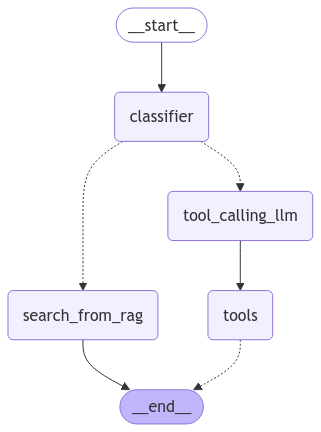

In [219]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, END, START
from langgraph.graph import MessagesState


def classify_condition(state: MessagesState) -> dict:
    user_query = state["messages"][-1].content

    if not isinstance(user_query, str):
        raise TypeError(f"Expected user_query to be a string, got {type(user_query)}")

    context_with_scores = vector_store.similarity_search_with_score(user_query)
    filtered_context = [res.page_content for res, score in context_with_scores if score > 0.65]

    if filtered_context:
        return {"next_node": "search_from_rag"}
    else:
        return {"next_node": "tool_calling_llm"}

def answer_to_user(state: MessagesState) -> dict:

    user_query = state["messages"][-1].content

    if not isinstance(user_query, str):
        raise TypeError(f"Expected user_query to be a string, got {type(user_query)}")

    context_with_scores = vector_store.similarity_search_with_score(user_query)
    filtered_context = [res.page_content for res, score in context_with_scores if score > 0.65]

    rag_answer = f"Based on the context: {filtered_context[0]}" if filtered_context else "No relevant context found."
    state["messages"].append(AIMessage(content=filtered_context[0]))
    return {"messages": state["messages"]}

def tool_calling_llm(state: MessagesState) -> dict:
    user_query = state["messages"][-1].content

    if not isinstance(user_query, str):
        raise TypeError(f"Expected user_query to be a string, got {type(user_query)}")

    response = llm_with_tools.invoke([HumanMessage(content=user_query)])
    state["messages"].append(response)
    return {"messages": state["messages"]}

builder = StateGraph(MessagesState)

builder.add_node("classifier", classify_condition)
builder.add_node("search_from_rag", answer_to_user)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([check_order_status,submit_complaint]))

builder.add_edge(START, "classifier")
builder.add_conditional_edges(
    "classifier",
    lambda state: state.get("next_node"),
    {
        "search_from_rag": "search_from_rag",
        "tool_calling_llm": "tool_calling_llm",
    },
)
builder.add_edge("tool_calling_llm", "tools")
builder.add_conditional_edges(
     "tools",
    tools_condition,
    {
        END: END,
    },
)
builder.add_edge("search_from_rag", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


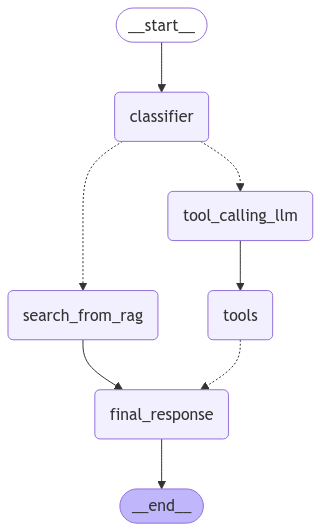

KeyError: '__end__'

In [218]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, END, START
from langgraph.graph import MessagesState
from typing_extensions import TypedDict
from langchain.prompts import PromptTemplate

# Define the state class
class State(MessagesState):
    user_query: str

# Define the final_response function
def final_response(state: MessagesState) -> dict:
    """
    Prepares the final response for the user by consolidating messages from previous nodes.
    Uses a prompt template to format the response based on the context and user query.
    """
    filtered_context = state["messages"]
    user_query = state["user_query"]



    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_query = msg.content
        elif isinstance(msg, AIMessage) and "filtered_context" in msg.content:
            filtered_context = msg.content["filtered_context"]
        if user_query and filtered_context:
            break

    # If no user query or filtered context is found, return a default response
    if not user_query or not filtered_context:
        state["messages"].append(AIMessage(content="No response generated. Missing user query or context."))
        return {"messages": state["messages"]}

    # Define the prompt template
    prompt_template = PromptTemplate(
        input_variables=["filtered_context", "user_query"],
        template="""
            You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
            If you don't know the answer, just say that you don't know.

            ### Question:
            {user_query}

            ### Context:
            {filtered_context}

            ### Guidelines for Responses:
            1. Answer based on the provided context.
            2. Be concise, friendly, and professional.

            ## Response:
        """
    )

    # Format the prompt with the user query and filtered context
    formatted_prompt = prompt_template.format(filtered_context=filtered_context, user_query=user_query)

    # Invoke the LLM to generate the final response
    final_result = llm.invoke(formatted_prompt)

    # Append the final response to the messages
    state["messages"].append(AIMessage(content=final_result))
    return {"messages": state["messages"]}

# Define the classify_condition function
def classify_condition(state: MessagesState) :
    # Extract the last user query from the messages
    if not state["messages"]:
        raise ValueError("No messages found in the state.")

    last_message = state["messages"][-1]
    if not isinstance(last_message, HumanMessage):
        raise TypeError(f"Expected the last message to be a HumanMessage, got {type(last_message)}")

    user_query = last_message.content

    if not isinstance(user_query, str):
        raise TypeError(f"Expected user_query to be a string, got {type(user_query)}")

    context_with_scores = vector_store.similarity_search_with_score(user_query)
    filtered_context = [res.page_content for res, score in context_with_scores if score > 0.65]

    if filtered_context:
        return {"next_node": "search_from_rag"}
    else:
        return {"next_node": "tool_calling_llm"}

# Define the answer_to_user function
def answer_to_user(state: MessagesState)  :
    user_query = state["messages"][-1].content

    if not isinstance(user_query, str):
        raise TypeError(f"Expected user_query to be a string, got {type(user_query)}")

    context_with_scores = vector_store.similarity_search_with_score(user_query)
    filtered_context = [res.page_content for res, score in context_with_scores if score > 0.65]

    rag_answer = f"Based on the context: {filtered_context[0]}" if filtered_context else "No relevant context found."
    state["messages"].append(AIMessage(content={"filtered_context": filtered_context[0]}))
    return {"messages": state["messages"]}

# Define the tool_calling_llm function
def tool_calling_llm(state: MessagesState) :
    user_query = state["messages"][-1].content

    if not isinstance(user_query, str):
        raise TypeError(f"Expected user_query to be a string, got {type(user_query)}")

    response = llm_with_tools.invoke([HumanMessage(content=user_query)])
    state["messages"].append(response)
    return {"messages": state["messages"]}

# Build the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("classifier", classify_condition)
builder.add_node("search_from_rag", answer_to_user)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([check_order_status, submit_complaint]))
builder.add_node("final_response", final_response)

# Add edges
builder.add_edge(START, "classifier")
builder.add_conditional_edges(
    "classifier",
    lambda state: state.get("next_node"),
    {
        "search_from_rag": "search_from_rag",
        "tool_calling_llm": "tool_calling_llm",
    },
)
builder.add_edge("tool_calling_llm", "tools")
builder.add_conditional_edges(
    "tools",
    tools_condition,
    {
        "final_response": "final_response",
    },
)
builder.add_edge("search_from_rag", "final_response")
builder.add_edge("final_response", END)

# Compile the graph
graph = builder.compile()

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Invoke the graph
from langchain_core.messages import HumanMessage

# Initialize the state with the user query
messages = [HumanMessage(content="What is the return policy?")]
state = {"messages": messages}

# Invoke the graph
result = graph.invoke(state)

# Print the result
print(result)
for m in result['messages']:
    m.pretty_print()

In [220]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="how we can register a complaint my order_id is 111 and email is ali@gmail.com and complaint is due to open the box")]
messages = graph.invoke({"messages": messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [HumanMessage(content='how we can register a complaint my order_id is 111 and email is ali@gmail.com and complaint is due to open the box', additional_kwargs={}, response_metadata={}, id='f628a0a2-303b-4d7a-8c03-409166f1b7f6'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'submit_complaint', 'arguments': '{"order_id": "111", "email": "ali@gmail.com", "complaint": "due to open the box"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-3723b0b0-671b-4c58-81f2-6350e60c3435-0', tool_calls=[{'name': 'submit_complaint', 'args': {'order_id': '111', 'email': 'ali@gmail.com', 'complaint': 'due to open the box'}, 'id': '68cddd3c-31fb-4f99-a136-4a79b8b2d693', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 21, 'total_tokens': 241, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='Complaint submitted successfully! Your complaint 

In [222]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="what is company shoes name")]
messages = graph.invoke({"messages": messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()
print(messages)

{'messages': [HumanMessage(content='what is company shoes name', additional_kwargs={}, response_metadata={}, id='69affcd3-c23c-4992-ac76-088a2b0d0ee0'), AIMessage(content="This question cannot be answered from the given context.  The available code only provides functions for checking order status and submitting complaints; there is no information about the company's name.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e62a942f-e56e-4956-8286-9d6c7fcfbb02-0', usage_metadata={'input_tokens': 194, 'output_tokens': 37, 'total_tokens': 231, 'input_token_details': {'cache_read': 0}})]}
================================ Human Message =================================

what is company shoes name
================================== Ai Message ==================================

This question cannot be answered from the given context.  The available code only provides functions for 

In [223]:

from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="how we can check my order status")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

how we can check my order status
================================== Ai Message ==================================

Q: What should I do if my order is not confirmed?
Ans: Check your email for confirmation or contact customer support with your order details.
Q: How do I cancel an order?
Ans: Go to "My Orders," select the order, and click "Cancel" before it is shipped.
Q: Can I place an order over the phone?
Ans: Yes, contact customer support for assistance.
Q: Can I make changes to an order after it has been placed?
Ans: Changes are possible only before the order is shipped. Contact support for help.
Q: How do I apply a discount code?
Ans: Enter the code at checkout in the "Promo Code" field and click "Apply."
Q: Can I save items for later?
Ans: Use the "Wishlist" feature to save items for future purchases.
Q: Is there a minimum order value?
Ans: Some promotions may require a minimum purchase amount. Check 

In [224]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="What is  return policy?")]
messages = graph.invoke({"messages":messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [HumanMessage(content='What is  return policy?', additional_kwargs={}, response_metadata={}, id='88e7dfbb-fdd9-4ccf-ad55-4d67acfd2164'), AIMessage(content="Q: What happens if I'm not home during delivery?\nAns: The carrier may attempt redelivery or leave the package at a secure location.\nQ: Can I change my shipping address after placing an order?\nAns: Address changes are possible only before the order is shipped.\nQ: What carriers do you use for shipping?\nAns: We partner with leading carriers like FedEx, UPS, and DHL.\nQ: Can I choose my preferred carrier?\nAns: Carrier selection may not be available, but you can contact support for assistance.\nQ: What do I do if my package is lost?\nAns: Contact customer support to initiate an investigation and resolve the issue.\nQ: What is your return policy?\nAns: We offer a 30-day return policy for unused and undamaged items in their original packaging.\nQ: Can I exchange an item instead of returning it?\nAns: Yes, exchanges are p

In [225]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content=" What do I do if my package is lost?")]
messages = graph.invoke({"messages": messages})
print(messages)
for m in messages['messages']:
    m.pretty_print()

{'messages': [HumanMessage(content=' What do I do if my package is lost?', additional_kwargs={}, response_metadata={}, id='f41013f5-4512-43f2-af01-0c5459bda272'), AIMessage(content="Q: What happens if I'm not home during delivery?\nAns: The carrier may attempt redelivery or leave the package at a secure location.\nQ: Can I change my shipping address after placing an order?\nAns: Address changes are possible only before the order is shipped.\nQ: What carriers do you use for shipping?\nAns: We partner with leading carriers like FedEx, UPS, and DHL.\nQ: Can I choose my preferred carrier?\nAns: Carrier selection may not be available, but you can contact support for assistance.\nQ: What do I do if my package is lost?\nAns: Contact customer support to initiate an investigation and resolve the issue.\nQ: What is your return policy?\nAns: We offer a 30-day return policy for unused and undamaged items in their original packaging.\nQ: Can I exchange an item instead of returning it?\nAns: Yes, ex